# Square Model

In [1]:
# Import Libraries

import numpy as np
import scipy
import matplotlib.pyplot as plt
from pprint import pprint

np.set_printoptions(precision=5, suppress=True, linewidth=100)

import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import tebd, dmrg, tdvp
from tenpy.networks.site import SpinHalfSite, SpinSite, FermionSite
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.algorithms.dmrg import DMRGEngine, TwoSiteDMRGEngine
from tenpy.algorithms.exact_diag import ExactDiag

tenpy.tools.misc.setup_logging(to_stdout="INFO")

import tenpy.linalg.np_conserved as npc
from tenpy.networks.site import SpinHalfSite
from tenpy.networks.mps import MPS
from tenpy.networks.mpo import MPO
from tenpy.networks.site import SpinSite
from tenpy.models.lattice import Chain
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel, CouplingMPOModel
from tenpy.models.spins import SpinModel
from tenpy.models import Lattice

In [2]:
def _parse_sites(sites, expected_number):
    try: 
        iter(sites)
    except TypeError:
        return [sites] * expected_number
    if len(sites) != expected_number:
        raise ValueError("need to specify a single site or exactly {0:d}, got {1:d}".format(expected_number, len(sites)))
    return sites

In [3]:
class Square(Lattice):
    dim = 2
    Lu = 1

    def __init__(self, Lx, Ly, sites, **kwargs):
        sites = _parse_sites(sites, 1)
        a1 = np.array([1, 0])
        a2 = np.array([0, 1])
        basis = np.array([a1, a2])
        
        A = np.array([0.0, 0.0])

        pos = [A]
        
        kwargs.setdefault("basis", basis)
        kwargs.setdefault("positions", pos)

        NN = []
        
        NN.append((0, 0, np.array([0, 1])))
        NN.append((0, 0, np.array([1, 0])))
        
        kwargs.setdefault("pairs", {})
        kwargs["pairs"].setdefault("nearest_neighbors", NN)

        nNN = []
        
        nNN.append((0, 0, np.array([1, 1])))
        nNN.append((0, 0, np.array([-1, 1])))

        kwargs["pairs"].setdefault("next_nearest_neighbors", nNN)

        Lattice.__init__(self, [Lx, Ly], sites, **kwargs)

In [4]:
sq = Square(4, 4, None)

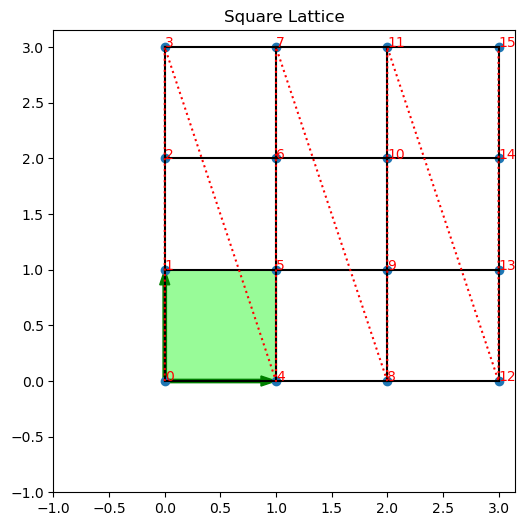

In [5]:
plt.figure(figsize=(6, 6))
plt.title("Square Lattice")
ax = plt.gca()
sq.plot_sites(ax)
sq.plot_coupling(ax)
sq.plot_order(ax, linestyle=":")
sq.plot_basis(ax)
ax.set_aspect("equal")
ax.set_xlim(-1)
ax.set_ylim(-1)
plt.show()

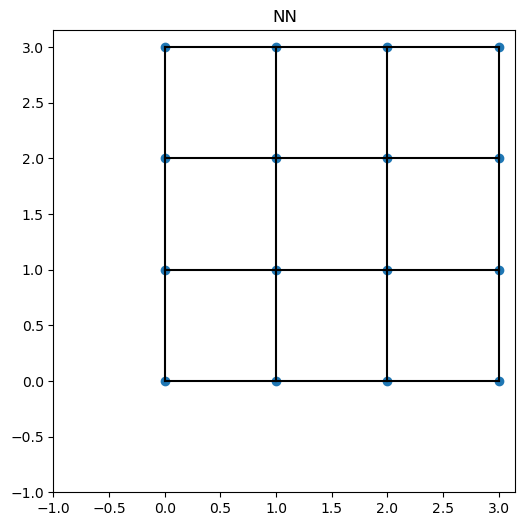

In [6]:
plt.figure(figsize=(6, 6))
plt.title("NN")
ax = plt.gca()
sq.plot_sites(ax)
sq.plot_coupling(ax)
ax.set_aspect("equal")
ax.set_xlim(-1)
ax.set_ylim(-1)
plt.show()

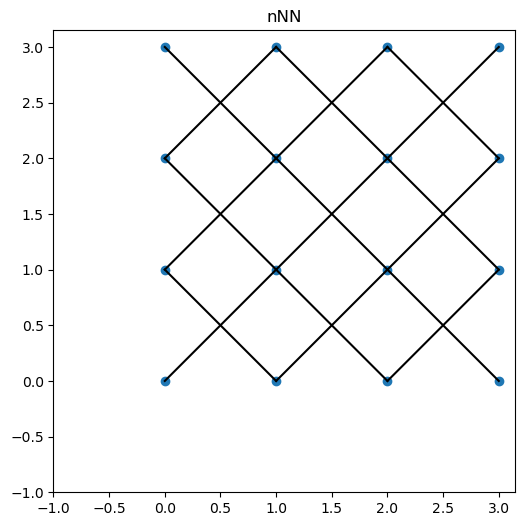

In [7]:
plt.figure(figsize=(6, 6))
plt.title("nNN")
ax = plt.gca()
sq.plot_sites(ax)
sq.plot_coupling(ax, coupling=sq.pairs["next_nearest_neighbors"])
ax.set_aspect("equal")
ax.set_xlim(-1)
ax.set_ylim(-1)
plt.show()

In [8]:
class IsingModel(CouplingMPOModel):
    def init_sites(self, model_params):
        conserve = model_params.get("conserve", "best")
        if conserve == "best":
            if model_params.get("hx", 0) == 0:
                conserve = "Sz"
            else:
                conserve = None
        return SpinHalfSite(conserve=conserve)

In [9]:
class SquareModel(IsingModel):
    default_lattice = Square
    force_default_lattice = True

    def init_sites(self, model_params):
        site = IsingModel.init_sites(self, model_params)
        return (site)

    def init_terms(self, model_params):
        J1 = model_params.get("J1", 1)
        J2 = model_params.get("J2", 1)

        for u1, u2, dx in self.lat.pairs["nearest_neighbors"]:
            self.add_coupling(J1, u1, "Sigmaz", u2, "Sigmaz", dx)

        for u1, u2, dx in self.lat.pairs["next_nearest_neighbors"]:
            self.add_coupling(J2, u1, "Sigmaz", u2, "Sigmaz", dx)

In [10]:
sq_model = SquareModel({"Lx": 4, "Ly": 4, "J1": 1, "J2": 0, 'bc_MPS': 'finite'})

INFO    : SquareModel: reading 'bc_MPS'='finite'
INFO    : SquareModel: reading 'Lx'=4
INFO    : SquareModel: reading 'Ly'=4
INFO    : SquareModel: reading 'J1'=1
INFO    : SquareModel: reading 'J2'=0


In [11]:
J2_arr = np.linspace(0, 1, 100)
E0_arr = np.array([])
Sz_arr = np.array([])

for J2 in J2_arr:
    sq_model = SquareModel({"Lx": 3, "Ly": 3, "J1": 1, "J2": J2, 'bc_MPS': 'finite'})
    sq_ed = ExactDiag(sq_model)
    sq_ed.build_full_H_from_mpo()
    sq_ed.full_diagonalization()
    E0, psi0 = sq_ed.groundstate()
    E0_arr = np.append(E0_arr, E0)

INFO    : SquareModel: reading 'bc_MPS'='finite'
INFO    : SquareModel: reading 'Lx'=3
INFO    : SquareModel: reading 'Ly'=3
INFO    : SquareModel: reading 'J1'=1
INFO    : SquareModel: reading 'J2'=0.0
INFO    : SquareModel: reading 'bc_MPS'='finite'
INFO    : SquareModel: reading 'Lx'=3
INFO    : SquareModel: reading 'Ly'=3
INFO    : SquareModel: reading 'J1'=1
INFO    : SquareModel: reading 'J2'=0.010101010101010102
INFO    : SquareModel: reading 'bc_MPS'='finite'
INFO    : SquareModel: reading 'Lx'=3
INFO    : SquareModel: reading 'Ly'=3
INFO    : SquareModel: reading 'J1'=1
INFO    : SquareModel: reading 'J2'=0.020202020202020204
INFO    : SquareModel: reading 'bc_MPS'='finite'
INFO    : SquareModel: reading 'Lx'=3
INFO    : SquareModel: reading 'Ly'=3
INFO    : SquareModel: reading 'J1'=1
INFO    : SquareModel: reading 'J2'=0.030303030303030304
INFO    : SquareModel: reading 'bc_MPS'='finite'
INFO    : SquareModel: reading 'Lx'=3
INFO    : SquareModel: reading 'Ly'=3
INFO    : Sq

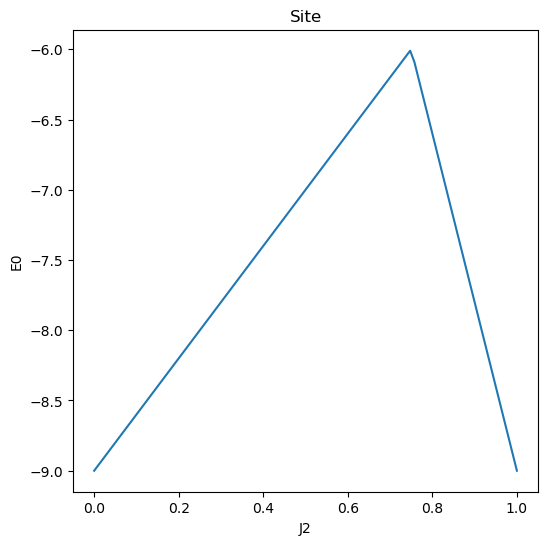

In [12]:
plt.figure(figsize=(6, 6))
plt.plot(J2_arr, E0_arr)
plt.title("Site")
plt.xlabel("J2")
plt.ylabel("E0")
plt.show()

In [22]:
J2_arr = np.linspace(0, 1, 100)
E0_arr = np.array([])
Sz_arr = np.array([])

for J2 in J2_arr:
    sq_model = SquareModel({"Lx": 2, "Ly": 2, "J1": 1, "J2": J2, 'bc_MPS': 'finite'})
    sq_ed = ExactDiag(sq_model)
    sq_ed.build_full_H_from_mpo()
    sq_ed.full_diagonalization()
    E0, psi0 = sq_ed.groundstate()
    E0_arr = np.append(E0_arr, E0)

INFO    : SquareModel: reading 'bc_MPS'='finite'
INFO    : SquareModel: reading 'Lx'=2
INFO    : SquareModel: reading 'Ly'=2
INFO    : SquareModel: reading 'J1'=1
INFO    : SquareModel: reading 'J2'=0.0
INFO    : SquareModel: reading 'bc_MPS'='finite'
INFO    : SquareModel: reading 'Lx'=2
INFO    : SquareModel: reading 'Ly'=2
INFO    : SquareModel: reading 'J1'=1
INFO    : SquareModel: reading 'J2'=0.010101010101010102
INFO    : SquareModel: reading 'bc_MPS'='finite'
INFO    : SquareModel: reading 'Lx'=2
INFO    : SquareModel: reading 'Ly'=2
INFO    : SquareModel: reading 'J1'=1
INFO    : SquareModel: reading 'J2'=0.020202020202020204
INFO    : SquareModel: reading 'bc_MPS'='finite'
INFO    : SquareModel: reading 'Lx'=2
INFO    : SquareModel: reading 'Ly'=2
INFO    : SquareModel: reading 'J1'=1
INFO    : SquareModel: reading 'J2'=0.030303030303030304
INFO    : SquareModel: reading 'bc_MPS'='finite'
INFO    : SquareModel: reading 'Lx'=2
INFO    : SquareModel: reading 'Ly'=2
INFO    : Sq

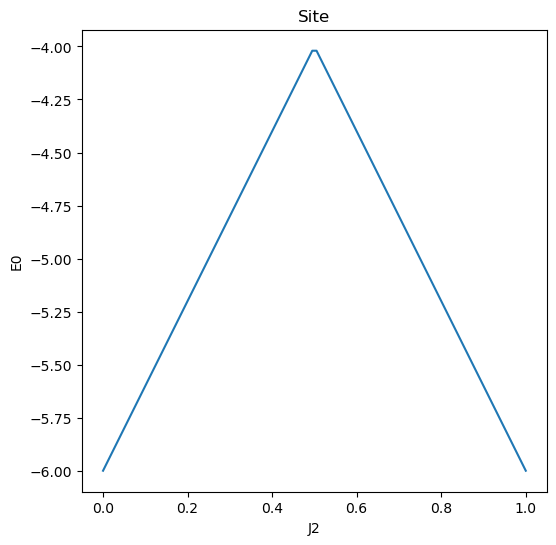

In [23]:
plt.figure(figsize=(6, 6))
plt.plot(J2_arr, E0_arr)
plt.title("Site")
plt.xlabel("J2")
plt.ylabel("E0")
plt.show()

In [ ]:
sq_model = SquareModel({"Lx": 2, "Ly": 2, "J1": 1, "J2": 0.5, "J3": 0, 'bc_MPS': 'finite', 'bc_x': 'open', 'bc_y': 'open'})
p_state = ['up'] * (sq_model.lat.N_sites)
psi = MPS.from_product_state(sq_model.lat.mps_sites(), p_state, "finite")
algorithm_params = {'trunc_params': {'chi_max': 100, 'svd_min': 1e-10}, "mixer": True}



In [41]:
eng.sweep_stats

{'sweep': [1, 2, 3],
 'N_updates': [4, 8, 12],
 'E': [6.0, 6.0, 6.0],
 'Delta_E': [nan, 0.0, 0.0],
 'S': [0.0, 0.0, 0.0],
 'Delta_S': [0.0, 0.0, 0.0],
 'max_S': [-0.0, -0.0, -0.0],
 'time': [0.017899036407470703, 0.034355878829956055, 0.04614567756652832],
 'max_trunc_err': [0.0, 0.0, 0.0],
 'max_E_trunc': [0.0, 0.0, 0.0],
 'max_chi': [1, 1, 1],
 'norm_err': [0.0, 0.0, 0.0]}

In [35]:
sq_model = SquareModel({"Lx": 2, "Ly": 2, "J1": 1, "J2": 0.5, "J3": 0, 'bc_MPS': 'finite', 'bc_x': 'open', 'bc_y': 'open'})
p_state = ['up'] * (sq_model.lat.N_sites)
psi = MPS.from_product_state(sq_model.lat.mps_sites(), p_state, "finite")
algorithm_params = {'trunc_params': {'chi_max': 100, 'svd_min': 1e-10}, "mixer": True}
eng = TwoSiteDMRGEngine(psi, sq_model, algorithm_params)
E, psi = eng.run()
E0_arr = np.append(E0_arr, E)

INFO    : SquareModel: reading 'bc_MPS'='finite'
INFO    : SquareModel: reading 'bc_x'='open'
INFO    : SquareModel: reading 'Lx'=2
INFO    : SquareModel: reading 'Ly'=2
INFO    : SquareModel: reading 'bc_y'='open'
INFO    : SquareModel: reading 'J1'=1
INFO    : SquareModel: reading 'J2'=0.5
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))

INFO    : TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : TwoSiteDMRGEngine: reading 'mixer'=True
INFO    : activate DensityMatrixMixer with initial amplitude 1e-05
INFO    : Running sweep with optimization
INFO    : trunc_params: reading 'chi_max'=100
INFO    : trunc_params: reading 'svd_min'=1e-10
INFO    : checkpoint after sweep 1
energy=5.0000000000000000, max S=-0.0000000000000000, age=4, norm_err=0.0e+00
Current memory usage 552.7MB, wall time: 0.0s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 0.0000e+00
chi: [1, 1, 1]
INFO    : Running sweep

In [36]:
sq_model.lat.boundary_conditions

['open', 'open']

In [37]:
J2_arr = np.linspace(0, 1, 100)
E0_arr = np.array([])

for J2 in J2_arr:
    sq_model = SquareModel({"Lx": 2, "Ly": 2, "J1": 1, "J2": J2, "J3": 0, 'bc_MPS': 'finite', 'bc_x': 'open', 'bc_y': 'open'})
    p_state = ['up'] * (sq_model.lat.N_sites)
    psi = MPS.from_product_state(sq_model.lat.mps_sites(), p_state, "finite")
    algorithm_params = {'trunc_params': {'chi_max': 100, 'svd_min': 1e-10}, "mixer": True}
    eng = TwoSiteDMRGEngine(psi, sq_model, algorithm_params)
    E, psi = eng.run()
    E0_arr = np.append(E0_arr, E)

INFO    : SquareModel: reading 'bc_MPS'='finite'
INFO    : SquareModel: reading 'bc_x'='open'
INFO    : SquareModel: reading 'Lx'=2
INFO    : SquareModel: reading 'Ly'=2
INFO    : SquareModel: reading 'bc_y'='open'
INFO    : SquareModel: reading 'J1'=1
INFO    : SquareModel: reading 'J2'=0.0
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))

INFO    : TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : TwoSiteDMRGEngine: reading 'mixer'=True
INFO    : activate DensityMatrixMixer with initial amplitude 1e-05
INFO    : Running sweep with optimization
INFO    : trunc_params: reading 'chi_max'=100
INFO    : trunc_params: reading 'svd_min'=1e-10
INFO    : checkpoint after sweep 1
energy=4.0000000000000000, max S=-0.0000000000000000, age=4, norm_err=0.0e+00
Current memory usage 552.7MB, wall time: 0.0s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 0.0000e+00
chi: [1, 1, 1]
INFO    : Running sweep

In [38]:
sq_model.lat.boundary_conditions

['open', 'open']

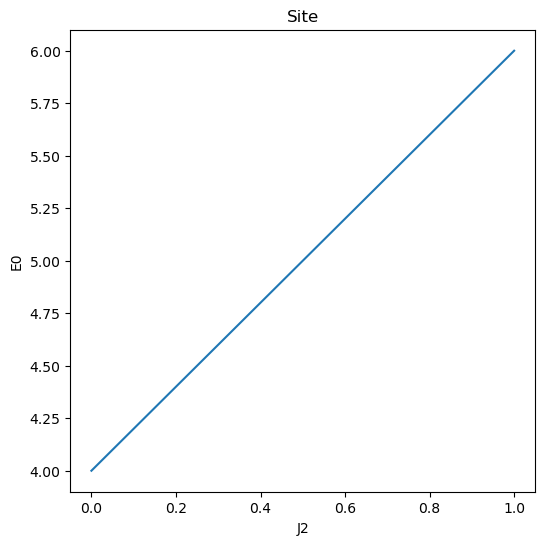

In [39]:
plt.figure(figsize=(6, 6))
plt.plot(J2_arr, E0_arr)
plt.title("Site")
plt.xlabel("J2")
plt.ylabel("E0")
plt.show()